In [1]:
import h5py
import pandas as pd
import joblib
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

In [2]:
path = ''
learning_path = './deep_learning_models/'

In [3]:
#Sequence length
seq_len = 10

filename = path + 'N-CMAPSS_DS03-012.h5'

dataset = filename[-11:-3]

# RUL classes  0: 0-29, 1: 15-29, 2: >= 30
ruls_inf = [30, 15, 0]
classes = [2, 1, 0]

In [4]:
with h5py.File(filename, 'r') as hdf:
    
    X_columns = np.array(hdf.get(f'X_s_dev')).shape[1]

    X_train = pd.concat([pd.DataFrame(np.array(hdf.get(f'W_dev')), columns=np.array(hdf.get('W_var')).astype('U')),
                pd.DataFrame(np.array(hdf.get('X_s_dev')), columns=np.array(hdf.get('X_s_var')).astype('U'))], axis=1)
    
    X_train.rename(columns={'alt':'Altitude'}, inplace=True)
    
    Xw_columns = X_train.shape[1]

    aux_train = pd.concat([pd.DataFrame(np.array(hdf.get('Y_dev')), columns=['RUL']),
                pd.DataFrame(np.array(hdf.get('A_dev')), columns=np.array(hdf.get('A_var')).astype('U')).astype('int64')], axis=1)                 

    aux_train.rename(columns={'unit':'Unit','cycle':'Cycle','Fc':'Class','hs':'State'}, inplace=True)
    
    aux_columns = aux_train.shape[1]
    
    X_test = pd.concat([pd.DataFrame(np.array(hdf.get(f'W_test')), columns=np.array(hdf.get('W_var')).astype('U')),
                pd.DataFrame(np.array(hdf.get('X_s_test')), columns=np.array(hdf.get('X_s_var')).astype('U'))], axis=1)
    
    X_test.rename(columns={'alt':'Altitude'}, inplace=True)
    
    aux_test = pd.concat([pd.DataFrame(np.array(hdf.get('Y_test')), columns=['RUL']),
                pd.DataFrame(np.array(hdf.get('A_test')), columns=np.array(hdf.get('A_var')).astype('U')).astype('int64')], axis=1)            

    aux_test.rename(columns={'unit':'Unit','cycle':'Cycle','Fc':'Class','hs':'State'}, inplace=True)
    
    
    # Since training sets are less than 70%, construct validation set from the test set

    train_units = aux_train['Unit'].unique()
    val_units =  aux_test['Unit'].unique()[:len(aux_test['Unit'].unique())//2]
    test_units = aux_test['Unit'].unique()[len(aux_test['Unit'].unique())//2:]
    
    
    test = pd.concat([aux_test, X_test], axis=1)

    # Take validation set from test set
    X_val = test[test['Unit'].isin(val_units)].iloc[:, -Xw_columns:].reset_index(drop=True)
    aux_val = test[test['Unit'].isin(val_units)].iloc[:, :aux_columns].reset_index(drop=True)

    #Update the remaining test set
    X_test = test[test['Unit'].isin(test_units)].iloc[:, -Xw_columns:].reset_index(drop=True)
    aux_test = test[test['Unit'].isin(test_units)].iloc[:, :aux_columns].reset_index(drop=True)

    del test

    # Compute length datasets
    train_len = len(X_train)
    val_len = len(X_val)
    test_len = len(X_test)
    total_len = train_len + val_len + test_len
    
    print(f'The train set: {round(train_len/total_len*100)}%  {train_len:,} observations. Units: {train_units}'.replace(',','.') + 
    f'\nThe val set:   {round(val_len/total_len*100)}%  {val_len:,} observations. Units: {val_units}'.replace(',','.') +
    f'\nThe test set:  {round(test_len/total_len*100)}%  {test_len:,} observations. Units: {test_units}'.replace(',','.'))

The train set: 57%  5.571.277 observations. Units: [1 2 3 4 5 6 7 8 9]
The val set:   22%  2.181.010 observations. Units: [10 11 12]
The test set:  21%  2.070.550 observations. Units: [13 14 15]


In [5]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

try:
    scaler = joblib.load(learning_path + f'{dataset}_scaler.gz')
except:
    joblib.dump(scaler, learning_path + f'{dataset}_scaler.gz')

del X_train, X_val, X_test

In [6]:
train = pd.concat([aux_train, X_train_scaled], axis=1)
val = pd.concat([aux_val, X_val_scaled], axis=1)
test = pd.concat([aux_test, X_test_scaled], axis=1)

del aux_train, aux_val, aux_test, X_train_scaled, X_val_scaled, X_test_scaled

In [7]:
# Rehsape data
X_train_state = np.empty((0,seq_len,X_columns))
y_train_state = np.empty((0,1))
X_train_rul = np.empty((0,seq_len,Xw_columns))
y_train_rul = np.empty((0,1))


for idx, unit in enumerate(list(train['Unit'].unique()), start=1):
    
    print(f"\nUNIT {idx} of {len(train['Unit'].unique())}: N. {unit} \nCYCLE of {train[train['Unit'] == unit]['Cycle'].unique()[-1]}: ", end = ' ')

    single_unit_state = np.empty((0,seq_len,X_columns))
    single_unit_rul = np.empty((0,seq_len,Xw_columns))

    c_idx = -1
    
    for cycle in list(train[train['Unit'] == unit]['Cycle'].unique()):
        
        print(cycle, end = ' ')

        X_cycle = train[(train['Unit'] == unit) & (train['Cycle'] == cycle)].iloc[:, -X_columns:].to_numpy()

        mod = len(X_cycle) % seq_len
        ran = len(X_cycle) // seq_len

        single_cycle_state = np.empty((0,seq_len,X_columns))
        for idx in range(0, ran):
            single_cycle_state = np.vstack((single_cycle_state, X_cycle[(mod + idx*seq_len): mod+seq_len + idx*seq_len].reshape(1, seq_len, X_columns) ))
  
        single_unit_state = np.vstack((single_unit_state, single_cycle_state))

        state = train[(train['Unit'] == unit) & (train['Cycle'] == cycle)]['State'].iloc[0]

        new_state = np.full((ran, 1), state)

        y_train_state = np.vstack((y_train_state, new_state))  

        if not state:
            
            single_cycle_rul = np.empty((0,seq_len,Xw_columns))

            X_cycle = train[(train['Unit'] == unit) & (train['Cycle'] == cycle)].iloc[:, -Xw_columns:].to_numpy()

            
            rul = train[(train['Unit'] == unit) & (train['Cycle'] == cycle)]['RUL'].iloc[0]
            
            # Find new starting RUL c_idx
            if c_idx == -1:
                for c_idx, value in enumerate(ruls_inf):             
                    if value <= rul:
                        break
            
            new_rul = np.full((ran, 1), classes[c_idx])
            
            if (rul == ruls_inf[c_idx]):
                c_idx += 1


            y_train_rul = np.vstack((y_train_rul, new_rul))    

            for idx in range(0, ran):
            
                single_cycle_rul = np.vstack((single_cycle_rul, X_cycle[(mod + idx*seq_len): mod+seq_len + idx*seq_len].reshape(1, seq_len, Xw_columns) ))
  
            single_unit_rul = np.vstack((single_unit_rul, single_cycle_rul))
            
    X_train_rul = np.vstack((X_train_rul, single_unit_rul))
    X_train_state = np.vstack((X_train_state, single_unit_state))




UNIT 1 of 9: N. 1 
CYCLE of 72:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 
UNIT 2 of 9: N. 2 
CYCLE of 73:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 
UNIT 3 of 9: N. 3 
CYCLE of 67:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 
UNIT 4 of 9: N. 4 
CYCLE of 60:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 
UNIT 5 of 9: N. 5 
CYCLE of 93:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20

In [8]:
print(X_train_state.shape)
print(y_train_state.shape)
print(X_train_rul.shape)
print(y_train_rul.shape)

(556823, 10, 14)
(556823, 1)
(371997, 10, 18)
(371997, 1)


In [9]:
# Rehsape data
X_val_state = np.empty((0,seq_len,X_columns))
y_val_state = np.empty((0,1))
X_val_rul = np.empty((0,seq_len,Xw_columns))
y_val_rul = np.empty((0,1))


for idx, unit in enumerate(list(val['Unit'].unique()), start=1):
    
    print(f"\nUNIT {idx} of {len(val['Unit'].unique())}: N. {unit} \nCYCLE of {val[val['Unit'] == unit]['Cycle'].unique()[-1]}: ", end = ' ')

    single_unit_state = np.empty((0,seq_len,X_columns))
    single_unit_rul = np.empty((0,seq_len,Xw_columns))

    c_idx = -1
    
    for cycle in list(val[val['Unit'] == unit]['Cycle'].unique()):
        
        print(cycle, end = ' ')

        X_cycle = val[(val['Unit'] == unit) & (val['Cycle'] == cycle)].iloc[:, -X_columns:].to_numpy()

        mod = len(X_cycle) % seq_len
        ran = len(X_cycle) // seq_len

        single_cycle_state = np.empty((0,seq_len,X_columns))
        for idx in range(0, ran):
            single_cycle_state = np.vstack((single_cycle_state, X_cycle[(mod + idx*seq_len): mod+seq_len + idx*seq_len].reshape(1, seq_len, X_columns) ))
  
        single_unit_state = np.vstack((single_unit_state, single_cycle_state))

        state = val[(val['Unit'] == unit) & (val['Cycle'] == cycle)]['State'].iloc[0]

        new_state = np.full((ran, 1), state)

        y_val_state = np.vstack((y_val_state, new_state))  

        if not state:
            
            single_cycle_rul = np.empty((0,seq_len,Xw_columns))

            X_cycle = val[(val['Unit'] == unit) & (val['Cycle'] == cycle)].iloc[:, -Xw_columns:].to_numpy()

            
            rul = val[(val['Unit'] == unit) & (val['Cycle'] == cycle)]['RUL'].iloc[0]
            
            # Find new starting RUL c_idx
            if c_idx == -1:
                for c_idx, value in enumerate(ruls_inf):             
                    if value <= rul:
                        break
            
            new_rul = np.full((ran, 1), classes[c_idx])
            
            if (rul == ruls_inf[c_idx]):
                c_idx += 1


            y_val_rul = np.vstack((y_val_rul, new_rul))    

            for idx in range(0, ran):
            
                single_cycle_rul = np.vstack((single_cycle_rul, X_cycle[(mod + idx*seq_len): mod+seq_len + idx*seq_len].reshape(1, seq_len, Xw_columns) ))
  
            single_unit_rul = np.vstack((single_unit_rul, single_cycle_rul))
            
    X_val_rul = np.vstack((X_val_rul, single_unit_rul))
    X_val_state = np.vstack((X_val_state, single_unit_state))




UNIT 1 of 3: N. 10 
CYCLE of 66:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 
UNIT 2 of 3: N. 11 
CYCLE of 59:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
UNIT 3 of 3: N. 12 
CYCLE of 93:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 

In [10]:
print(X_val_state.shape)
print(y_val_state.shape)
print(X_val_rul.shape)
print(y_val_rul.shape)

(218001, 10, 14)
(218001, 1)
(151384, 10, 18)
(151384, 1)


In [11]:
# Rehsape data
X_test_state = np.empty((0,seq_len,X_columns))
y_test_state = np.empty((0,1))
X_test_rul = np.empty((0,seq_len,Xw_columns))
y_test_rul = np.empty((0,1))


for idx, unit in enumerate(list(test['Unit'].unique()), start=1):
    
    print(f"\nUNIT {idx} of {len(test['Unit'].unique())}: N. {unit} \nCYCLE of {test[test['Unit'] == unit]['Cycle'].unique()[-1]}: ", end = ' ')

    single_unit_state = np.empty((0,seq_len,X_columns))
    single_unit_rul = np.empty((0,seq_len,Xw_columns))

    c_idx = -1
    
    for cycle in list(test[test['Unit'] == unit]['Cycle'].unique()):
        
        print(cycle, end = ' ')

        X_cycle = test[(test['Unit'] == unit) & (test['Cycle'] == cycle)].iloc[:, -X_columns:].to_numpy()

        mod = len(X_cycle) % seq_len
        ran = len(X_cycle) // seq_len

        single_cycle_state = np.empty((0,seq_len,X_columns))
        for idx in range(0, ran):
            single_cycle_state = np.vstack((single_cycle_state, X_cycle[(mod + idx*seq_len): mod+seq_len + idx*seq_len].reshape(1, seq_len, X_columns) ))
  
        single_unit_state = np.vstack((single_unit_state, single_cycle_state))

        state = test[(test['Unit'] == unit) & (test['Cycle'] == cycle)]['State'].iloc[0]

        new_state = np.full((ran, 1), state)

        y_test_state = np.vstack((y_test_state, new_state))  

        if not state:
            
            single_cycle_rul = np.empty((0,seq_len,Xw_columns))

            X_cycle = test[(test['Unit'] == unit) & (test['Cycle'] == cycle)].iloc[:, -Xw_columns:].to_numpy()

            
            rul = test[(test['Unit'] == unit) & (test['Cycle'] == cycle)]['RUL'].iloc[0]
            
            # Find new starting RUL c_idx
            if c_idx == -1:
                for c_idx, value in enumerate(ruls_inf):             
                    if value <= rul:
                        break
            
            new_rul = np.full((ran, 1), classes[c_idx])
            
            if (rul == ruls_inf[c_idx]):
                c_idx += 1


            y_test_rul = np.vstack((y_test_rul, new_rul))    

            for idx in range(0, ran):
            
                single_cycle_rul = np.vstack((single_cycle_rul, X_cycle[(mod + idx*seq_len): mod+seq_len + idx*seq_len].reshape(1, seq_len, Xw_columns) ))
  
            single_unit_rul = np.vstack((single_unit_rul, single_cycle_rul))
            
    X_test_rul = np.vstack((X_test_rul, single_unit_rul))
    X_test_state = np.vstack((X_test_state, single_unit_state))




UNIT 1 of 3: N. 13 
CYCLE of 77:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 
UNIT 2 of 3: N. 14 
CYCLE of 76:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 
UNIT 3 of 3: N. 15 
CYCLE of 67:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 

In [12]:
print(X_test_state.shape)
print(y_test_state.shape)
print(X_test_rul.shape)
print(y_test_rul.shape)

(206945, 10, 14)
(206945, 1)
(144167, 10, 18)
(144167, 1)


State
0        371997
1        184826
dtype: int64

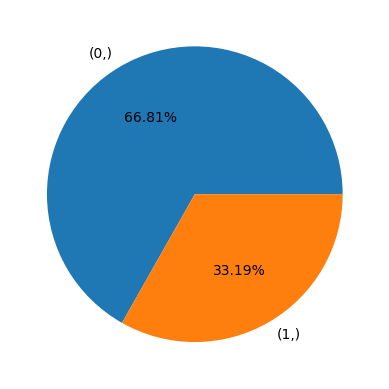

In [13]:
plot = pd.DataFrame(y_train_state, dtype='int64').value_counts().plot.pie(autopct='%.2f%%', label='')
pd.DataFrame(y_train_state, columns = ['State'], dtype='int64').value_counts()

RUL
2      137731
0      118907
1      115359
dtype: int64

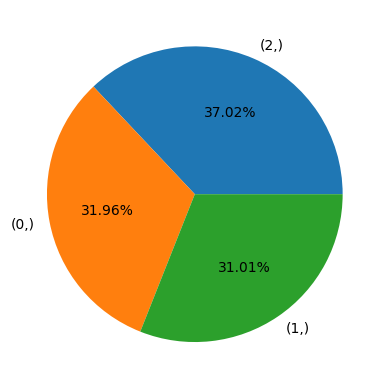

In [14]:
plot = pd.DataFrame(y_train_rul, dtype='int64').value_counts().plot.pie(autopct='%.2f%%', label='')
pd.DataFrame(y_train_rul, columns = ['RUL'], dtype='int64').value_counts()

State
0        151384
1         66617
dtype: int64

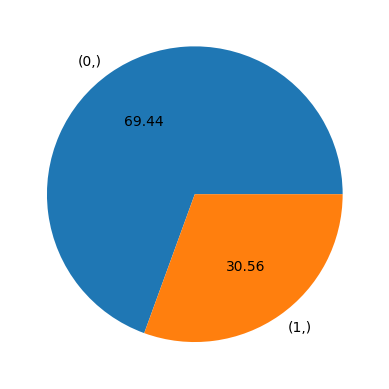

In [15]:
plot = pd.DataFrame(y_val_state, dtype='int64').value_counts().plot.pie(autopct='%.2f', label='')
pd.DataFrame(y_val_state, columns = ['State'], dtype='int64').value_counts()

RUL
2      52737
0      50746
1      47901
dtype: int64

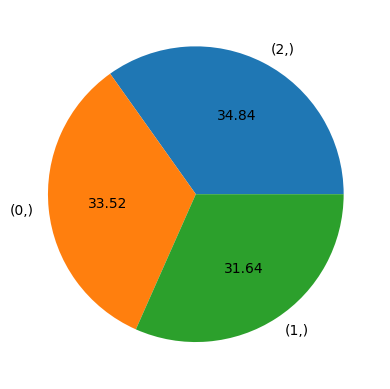

In [16]:
plot = pd.DataFrame(y_val_rul, dtype='int64').value_counts().plot.pie(autopct='%.2f', label='')
pd.DataFrame(y_val_rul, columns = ['RUL'], dtype='int64').value_counts()

State
0        144167
1         62778
dtype: int64

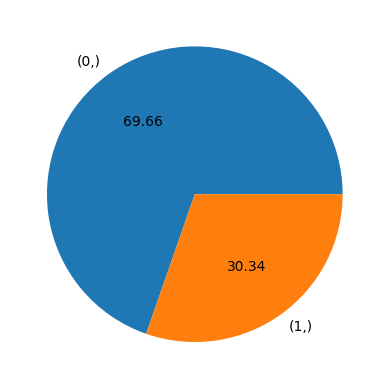

In [17]:
plot = pd.DataFrame(y_test_state, dtype='int64').value_counts().plot.pie(autopct='%.2f', label='')
pd.DataFrame(y_test_state, columns = ['State'], dtype='int64').value_counts()

RUL
2      59136
0      42970
1      42061
dtype: int64

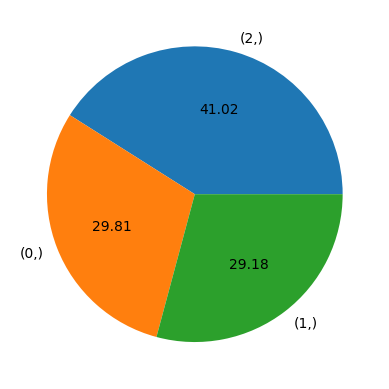

In [18]:
plot = pd.DataFrame(y_test_rul, dtype='int64').value_counts().plot.pie(autopct='%.2f', label='')
pd.DataFrame(y_test_rul, columns = ['RUL'], dtype='int64').value_counts()

In [19]:
model = Sequential()

model.add(Bidirectional(LSTM(16, return_sequences=True, recurrent_dropout = 0.1), input_shape=(X_train_state.shape[1], X_train_state.shape[2])))
model.add(Bidirectional(LSTM(16, return_sequences=False, recurrent_dropout = 0.1)))

model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

opt = Adam(learning_rate=0.001)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt, 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 10, 32)           3968      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 10,802
Trainable params: 10,802
Non-trainable params: 0
_________________________________________________________________


In [20]:
epochs = 10
tot_epochs = []

train_loss = []
val_loss = []

train_acc = []
val_acc = []

loss = 1

try:
    model = load_model(learning_path + f'state_{dataset}_model_{seq_len}.h5')
except:
    for epoch in range(1, epochs+1):
        print(f'Epoch {epoch}/{epochs}')
        tot_epochs.append(epoch)
        history =  model.fit(X_train_state, y_train_state, validation_data=(X_val_state, y_val_state), verbose=1, epochs=1)
        train_loss.append(round(history.history['loss'][0],4))
        train_acc.append(round(history.history['accuracy'][0],4))
        val_loss.append(round(history.history['val_loss'][0],4))
        val_acc.append(round(history.history['val_accuracy'][0],4))
        if val_loss[epoch-1] <= loss:
            model.save(learning_path + f'state_{dataset}_model_{seq_len}.h5')
            loss = val_loss[epoch-1]

In [21]:
scores = model.evaluate(X_test_state, y_test_state)

6468/6468 [==============================] - 26s 4ms/step - loss: 0.1953 - accuracy: 0.9220


In [22]:
# Obtain a classification report
pred = model.predict(X_test_state)
y_pred = np.argmax(pred, axis=1)
print(classification_report(y_test_state, y_pred))

6468/6468 [==============================] - 24s 3ms/step
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94    144167
         1.0       0.85      0.90      0.88     62778

    accuracy                           0.92    206945
   macro avg       0.90      0.92      0.91    206945
weighted avg       0.92      0.92      0.92    206945



In [23]:
model = Sequential()

model.add(Bidirectional(LSTM(16, return_sequences=True, recurrent_dropout = 0.1), input_shape=(X_train_rul.shape[1], X_train_rul.shape[2])))
model.add(Bidirectional(LSTM(16, return_sequences=False, recurrent_dropout = 0.1)))

model.add(Dense(16, activation='relu'))
model.add(Dense(len(classes), activation='softmax'))

opt = Adam(learning_rate=0.001)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt, 
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 10, 32)           4480      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 3)                 51        
                                                                 
Total params: 11,331
Trainable params: 11,331
Non-trainable params: 0
_________________________________________________________________


In [24]:
epochs = 10
tot_epochs = []

train_loss = []
val_loss = []

train_acc = []
val_acc = []

loss = 1

try:
    model = load_model(learning_path + f'rul_{dataset}_model_{seq_len}.h5')
except:
    for epoch in range(1, epochs+1):
        print(f'Epoch {epoch}/{epochs}')
        tot_epochs.append(epoch)
        history =  model.fit(X_train_rul, y_train_rul, validation_data=(X_val_rul, y_val_rul), verbose=1, epochs=1)
        train_loss.append(round(history.history['loss'][0],4))
        train_acc.append(round(history.history['accuracy'][0],4))
        val_loss.append(round(history.history['val_loss'][0],4))
        val_acc.append(round(history.history['val_accuracy'][0],4))
        if val_loss[epoch-1] <= loss:
            model.save(learning_path + f'rul_{dataset}_model_{seq_len}.h5')
            loss = val_loss[epoch-1]

In [25]:
scores = model.evaluate(X_test_rul, y_test_rul)

4506/4506 [==============================] - 25s 5ms/step - loss: 0.2330 - accuracy: 0.9109


In [26]:
# Obtain a classification report
pred = model.predict(X_test_rul)
y_pred = np.argmax(pred, axis=1)
print(classification_report(y_test_rul, y_pred))

4506/4506 [==============================] - 21s 4ms/step
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96     42970
         1.0       0.81      0.91      0.86     42061
         2.0       0.96      0.87      0.91     59136

    accuracy                           0.91    144167
   macro avg       0.91      0.92      0.91    144167
weighted avg       0.92      0.91      0.91    144167

